In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm
tqdm.pandas(desc='Progress')

import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import time

/home/elshan/Projects/Chatbot_pytorch/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/elshan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
max_features = 120000

In [3]:
data = pd.read_csv(r'questions.csv')
data.columns =['text', 'target']
print("Name: ", (data.target == 1).sum()) # Name
print("No Name: ", (data.target == 0).sum()) # No Name
display(data)

Name:  101
No Name:  255


,text,target
0,What is ur name?,1
1,Who are you?,1
2,What's ur name?,1
3,Can I have ur name?,1
4,Can I have ur name?,1
...,...,...
513,change transport preferences,5
514,change the transport preferences,5
515,i want to make some changes to my transport pr...,5
516,i would like to make some changes to my transp...,5


In [4]:
# Finding the maxLen
maxLen = len(max(data["text"], key=len).split()) + 5
maxLen

22

#### Preprocessing

In [5]:
count_data = data.groupby('target').aggregate({'text':'count'}).reset_index().sort_values('text',ascending=False)
count_data.head()

,target,text
0,0,255
1,1,101
3,3,62
2,2,47
4,4,31


In [6]:
data['target'].unique()

array([1, 0, 2, 3, 4, 5])

In [7]:
train_X, test_X, train_y, test_y = train_test_split(data.text, data.target, test_size=0.1,shuffle=True, random_state=2023, stratify=data.target)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023, stratify=y_train) # 0.25 x 0.8 = 0.2

print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)


Train shape :  (466,)
Test shape :  (52,)


In [8]:
def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return text

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [9]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [10]:
# GRADED FUNCTION: sentences_to_indices

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`. 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
   # m = X.shape[0] 
    m = len(X)                                  # number of training examples
   # print(m)
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    lst=[]
    for i in range(m):  # loop over training examples
       # print(X[i])
        # Convert the ith training sentence in lower case and clean, and then split is into words(with word_tokenize). You should get a list of words.
        sentence =clean_text(clean_numbers(replace_contractions(X[i].lower())))
        sentence_words = word_tokenize(sentence)
                      
        # Initialize j to 0
        j = 0

        # Loop over the words of 
        
        for w in sentence_words:
            if j < 22:
                if w in word_to_index:
                    # Set the (i,j)th entry of X_indices to the index of the correct word.
                    X_indices[i, j] = word_to_index[w]
                    # Increment j to j + 1
                    j = j + 1
                else:
                    lst.append(w)
                    j = j + 1
            else: break            

    return X_indices

In [11]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, word_to_vec_map

In [12]:
# word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('model/glove.6B.50d.txt')

In [13]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def pretrained_embedding_layer():
    word_to_index,  word_to_vec_map = read_glove_vecs('model/glove.6B.50d.txt')
    embeddings_index = word_to_vec_map
    word_index = word_to_index
    
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = embeddings_index["cucumber"].shape[0] 

    # nb_words = min(max_features, len(word_index)+1)
    nb_words = len(word_index)+1
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix, embed_size,word_to_index,  word_to_vec_map 

In [14]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

In [15]:
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [16]:
embedding_matrix, embed_size,word_to_index,  word_to_vec_map  = pretrained_embedding_layer()

In [17]:
class BiLSTM(nn.Module):
    
    def __init__(self,word_to_index,maxLen):
        super(BiLSTM, self).__init__()
        self.word_to_index = word_to_index
        self.maxLen = maxLen
        self.hidden_size = 32
        drp = 0.5
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
       # print(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [18]:
train_X = sentences_to_indices(train_X.to_numpy(), word_to_index, maxLen)
# Y_train_oh = convert_to_one_hot(Y_train)

test_X = sentences_to_indices(test_X.to_numpy(), word_to_index, maxLen)
# Y_val_oh = convert_to_one_hot(y_val)

In [19]:
n_epochs = 200
batch_size = 32
model = BiLSTM(word_to_index, maxLen)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=9.5e-2)
model.cpu()

# Load train and test in cpu Memory
x_train = torch.tensor(train_X, dtype=torch.long).cpu()
y_train = torch.tensor(train_y, dtype=torch.long).cpu()
x_cv = torch.tensor(test_X, dtype=torch.long).cpu()
y_cv = torch.tensor(test_y, dtype=torch.long).cpu()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred, dim=1).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

Epoch 1/200 	 loss=1.6616 	 val_loss=1.5271  	 val_acc=0.5000  	 time=0.41s
Epoch 2/200 	 loss=1.5136 	 val_loss=1.4536  	 val_acc=0.5000  	 time=0.28s
Epoch 3/200 	 loss=1.4706 	 val_loss=1.4309  	 val_acc=0.5000  	 time=0.33s
Epoch 4/200 	 loss=1.4615 	 val_loss=1.4257  	 val_acc=0.5000  	 time=0.35s
Epoch 5/200 	 loss=1.4557 	 val_loss=1.4183  	 val_acc=0.5000  	 time=0.29s
Epoch 6/200 	 loss=1.4460 	 val_loss=1.4150  	 val_acc=0.5000  	 time=0.32s
Epoch 7/200 	 loss=1.4426 	 val_loss=1.4078  	 val_acc=0.5000  	 time=0.35s
Epoch 8/200 	 loss=1.4343 	 val_loss=1.4021  	 val_acc=0.5000  	 time=0.36s
Epoch 9/200 	 loss=1.4241 	 val_loss=1.3967  	 val_acc=0.5000  	 time=0.40s
Epoch 10/200 	 loss=1.4142 	 val_loss=1.3899  	 val_acc=0.5000  	 time=0.34s
Epoch 11/200 	 loss=1.4224 	 val_loss=1.3786  	 val_acc=0.5000  	 time=0.42s
Epoch 12/200 	 loss=1.3880 	 val_loss=1.3655  	 val_acc=0.5000  	 time=0.48s
Epoch 13/200 	 loss=1.3692 	 val_loss=1.3453  	 val_acc=0.5000  	 time=0.33s
Epoch 14

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

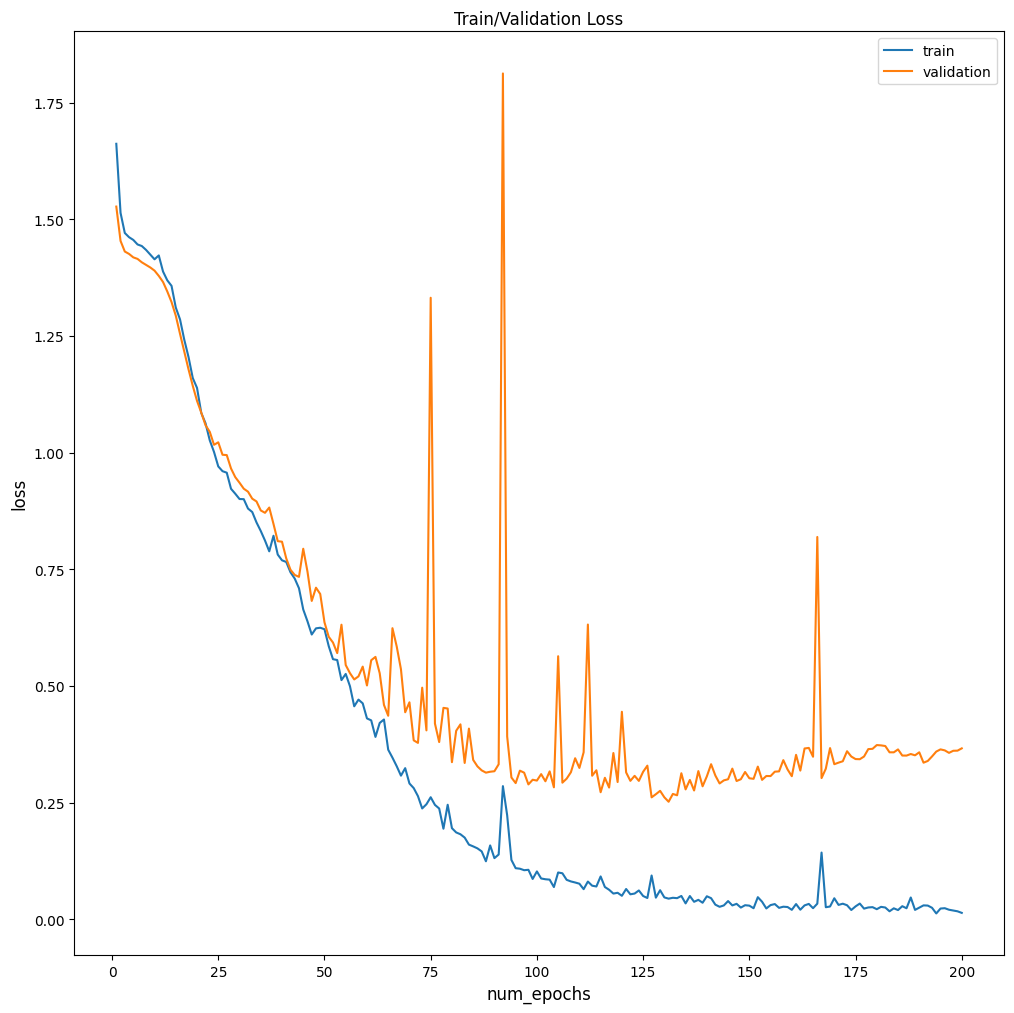

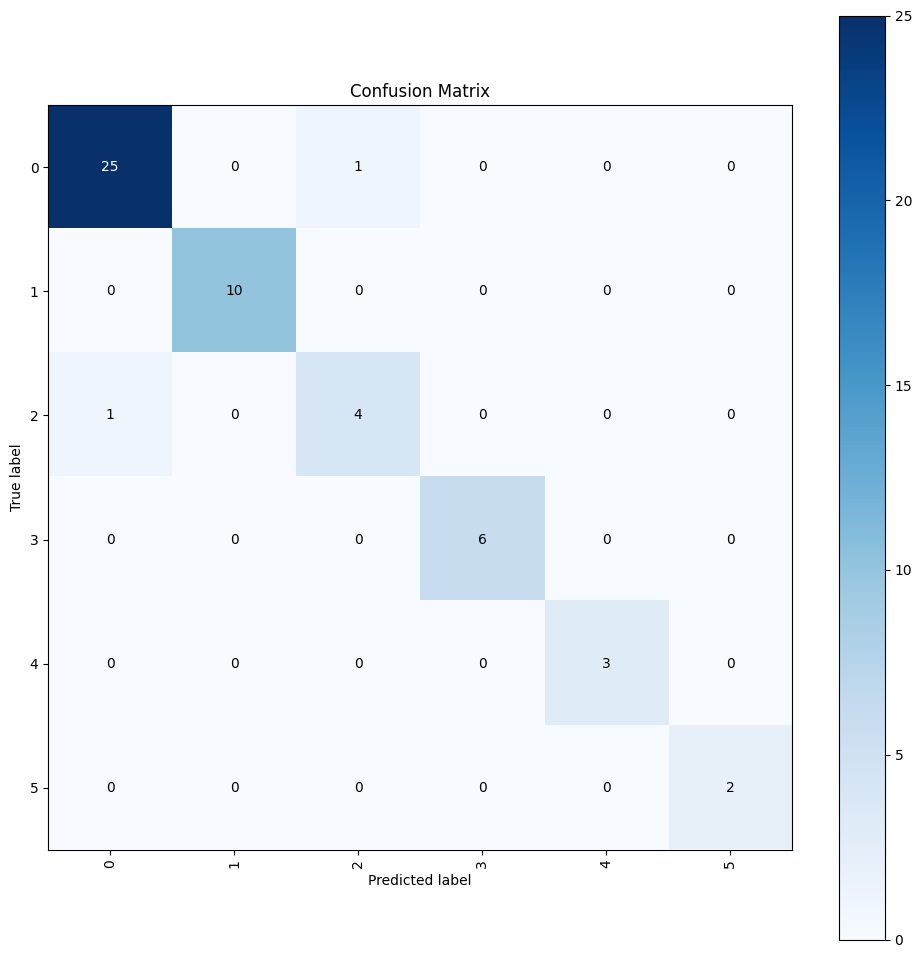

In [20]:
plot_graph(n_epochs)

import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [21]:
def predict_single(x,model):    
    x = sentences_to_indices(np.array(x), model.word_to_index, model.maxLen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cpu()

    pred = model(x).detach()
    pred = F.softmax(pred,dim=1).cpu().numpy()

    pred = pred.argmax(axis=1)

   # pred = le.classes_[pred]
    return pred

In [22]:
questions_en = [
    "What's his name?"
    ,'today weather is bad'
    ,'tell me a story'
    ,"what are our names?"
    ,"what is your brother\'s name?"
    ,"call me Ted"
    ,"can you play on guitar?"
    ,"tomorrow it will rain"
    ,"what are your cousins' names?"
    ,"How are you?"
    ,"How are you doing?"
    ,"What’s up?"
    ,"Good morning"
    ,"Tell me something"
    ,"Ok I’ll do that now"
    ,"Hello, Thank you, Goodbye","How can you help me?"
    ,"what can you do?"
    ,"Happy birthday!"
    ,"I have a question"
    ,"can you help me?"
    ,"Hello, my name is John"
    ,'What is your name?'
    ,'Who are you?'
    ,'can you tell me your name?'
    ,'May I have your name?'
    ,'Sorry! Can I have your name again?'
    ,'repeat your name?'
    ,"Can I have your name?"
    ,"Can you tell me your name?"
    ,"can you tell him your name?"
    ,"Hi, my name is Elshan"
    ,"your name?"
    ,"What are you named?"
    ,"What can I call you?"
    ,"What do you call yourself?"
    ,"What does everyone call you?"
    ,"I am  Sam, and you?"
    ,"How can I address you?"
    ,"what would your name be?"
    ,"tell me your name?"
    ,"let's go to centre"
    ,'I want to go to office'
    ,"I want to go to germany"
    ,"which transport should i take to arrive to rome from milan"
    ,"i want to order a taxi"
    ,"add a new event 18 June via Torini 12 at 13"
    ,"tomorrow i want to go to centre"
    ,"let's organize trip for the next week"
    ,"on thursday i want to go home"
    ,"next week i want to go from via Ippodromo, 5 to via Garibaldi, 4"
    ,"change my events"
    ,"modify the last event"
    ,"transport preferences"
]
for i in questions_en:
    print(i,': ', predict_single([i] ,model)[0] )

What's his name? :  0
today weather is bad :  0
tell me a story :  0
what are our names? :  0
what is your brother's name? :  0
call me Ted :  0
can you play on guitar? :  0
tomorrow it will rain :  0
what are your cousins' names? :  0
How are you? :  0
How are you doing? :  0
What’s up? :  0
Good morning :  0
Tell me something :  0
Ok I’ll do that now :  0
Hello, Thank you, Goodbye :  0
How can you help me? :  0
what can you do? :  0
Happy birthday! :  0
I have a question :  0
can you help me? :  0
Hello, my name is John :  1
What is your name? :  1
Who are you? :  1
can you tell me your name? :  1
May I have your name? :  1
Sorry! Can I have your name again? :  1
repeat your name? :  1
Can I have your name? :  1
Can you tell me your name? :  1
can you tell him your name? :  1
Hi, my name is Elshan :  1
your name? :  1
What are you named? :  1
What can I call you? :  1
What do you call yourself? :  1
What does everyone call you? :  1
I am  Sam, and you? :  1
How can I address you? :  

In [23]:
# x = ["i want to order a taxi"] 
# predict_single(x,model)[0] 

In [25]:
# model_scripted = torch.jit.script(model) # Export to TorchScript
# model_scripted.save('models/model_classification.pt') # Save